# Laboratorium 4: Transformata Census

## 1. Teoria

### Transformata Census

Transformata Census to metoda reprezentacji lokalnych regionów obrazu w postaci ciągów binarnych. Jest wykorzystywana głównie do porównywania podobieństwa między fragmentami obrazów.

**Zasada działania:**

Dla każdego piksela w obrazie:
1. Wybieramy okno o rozmiarze n×n (np. 3×3, 5×5) z pikselem centralnym
2. Porównujemy wartość piksela centralnego z wartościami wszystkich sąsiednich pikseli w oknie
3. Dla każdego sąsiada:
   - Jeśli wartość sąsiada < wartość centralna → bit = 0
   - Jeśli wartość sąsiada ≥ wartość centralna → bit = 1
4. Otrzymany ciąg bitów tworzy reprezentację Census dla tego piksela

**Przykład dla okna 3×3:**

```
Obraz wejściowy:        Porównanie z centrum (50):
┌────────────┐          ┌────────────┐
│ 45  60  30 │          │  0   1   0 │
│ 55  50  40 │    →     │  1   X   0 │
│ 70  35  65 │          │  1   0   1 │
└────────────┘          └────────────┘

Legenda: 0 = piksel < centrum
         1 = piksel ≥ centrum
```
```
Ciąg Census (czytany "ślimakiem" od lewego górnego rogu, zgodnie z ruchem wskazówek zegara):
Kolejność: 45→60→30→40→65→70→55→35
Wynik:      0  1  0  0  1  1  1  0  = 01001110 (78 w systemie dziesiętnym)

Wizualizacja kolejności odczytu "ślimakiem":
┌────────────┐
│  1→ 2→ 3  │
│        ↓  │
│  8  X  4  │
│  ↑     ↓  │
│  7← 6← 5  │
└────────────┘

**Uwaga:** Odczyt "ślimakiem" (spiralny) umożliwia badanie niezmienniczości względem obrotów obrazu, w przeciwieństwie do odczytu wierszami.
```

### Odległość Hamminga

Do porównywania dwóch reprezentacji Census używamy **odległości Hamminga** - liczby bitów, na których dwa ciągi binarne się różnią.

**Przykład:**
```
Ciąg 1: 01001001
Ciąg 2: 01101000
        ___^__^_
Odległość Hamminga = 2 (różnice na pozycjach 3 i 7)
```

**Zastosowania:**
- Stereo vision (dopasowywanie punktów między obrazami)
- Detekcja zmian w sekwencjach obrazów
- Rozpoznawanie tekstur
- Tracking obiektów

## 2. Kod startowy

### 2.1 Import bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen

# Konfiguracja wyświetlania
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

### 2.2 Funkcje pomocnicze

In [2]:
def rgb_to_gray(image):
    """
    Konwertuje obraz RGB do skali szarości.
    
    Parametry:
    image (numpy.ndarray): Obraz RGB
    
    Zwraca:
    numpy.ndarray: Obraz w skali szarości
    """
    if len(image.shape) == 3:
        # Wzór: Y = 0.299*R + 0.587*G + 0.114*B
        return np.dot(image[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
    return image


def show_images(images, titles=None, imgsize = 5, cmap='gray'):
    """
    Wyświetla wiele obrazów obok siebie.
    
    Parametry:
    images (list): Lista obrazów do wyświetlenia
    titles (list): Lista tytułów dla każdego obrazu
    cmap (str): Mapa kolorów (domyślnie 'gray')
    figsize (tuple): Rozmiar figury
    """

    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(imgsize*n, imgsize))
    if n == 1:
        axes = [axes]
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img, cmap=cmap)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

### 2.3 Wczytanie obrazu testowego

Rozmiar obrazu Lenna: (100, 100)
Typ danych: uint8
Zakres wartości: [14, 242]


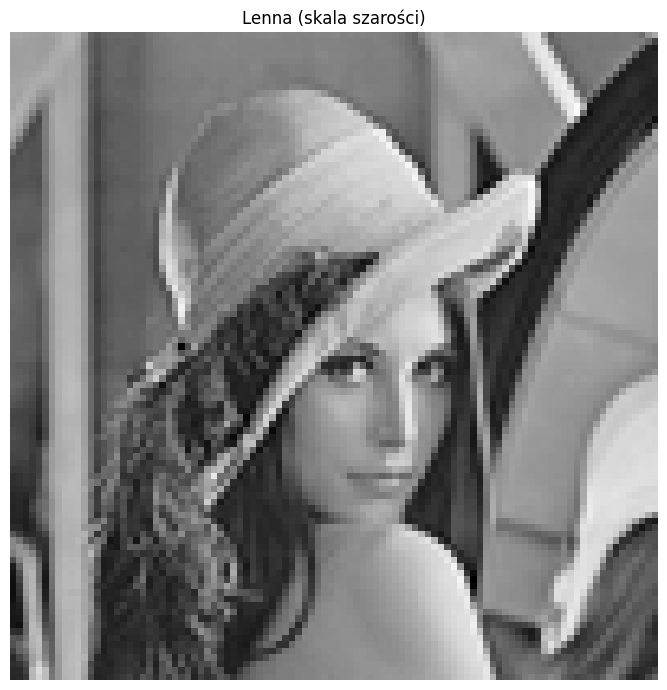

In [3]:
# Wczytanie obrazu testowego z GitHub
url_lenna = 'https://raw.githubusercontent.com/kbor89/TWiPO/main/images/lenna.png'

# Wczytanie obrazu z URL
img_lenna = np.array(Image.open(urlopen(url_lenna)))

# Konwersja do skali szarości
img_lenna_gray = rgb_to_gray(img_lenna).astype(np.uint8)

# Zmniejszenie obrazu do 100x100
img_lenna_gray = np.array(Image.fromarray(img_lenna_gray).resize((100, 100), Image.LANCZOS))


print(f"Rozmiar obrazu Lenna: {img_lenna_gray.shape}")
print(f"Typ danych: {img_lenna_gray.dtype}")
print(f"Zakres wartości: [{img_lenna_gray.min()}, {img_lenna_gray.max()}]")

show_images([img_lenna_gray], ['Lenna (skala szarości)'], 7)

### 2.4 Generowanie obrazów testowych

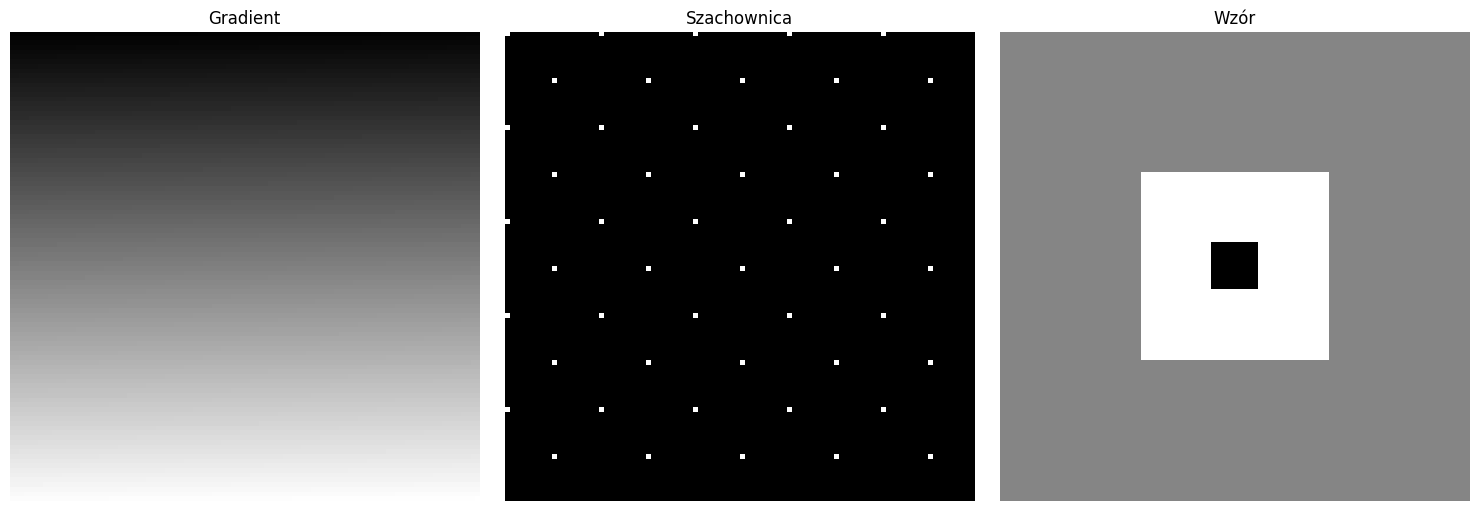

In [4]:
# Tworzenie przykładowych obrazów testowych
def create_test_images():
    # Obraz 1: Gradient
    img1 = np.linspace(0, 255, 100*100).reshape(100, 100).astype(np.uint8)
    
    # Obraz 2: Szachownica
    img2 = np.zeros((100, 100), dtype=np.uint8)
    img2[::20, ::20] = 255
    img2[10::20, 10::20] = 255
    
    # Obraz 3: Prosty wzór
    img3 = np.ones((100, 100), dtype=np.uint8) * 128
    img3[30:70, 30:70] = 200
    img3[45:55, 45:55] = 50
    
    return img1, img2, img3

test_img1, test_img2, test_img3 = create_test_images()
show_images([test_img1, test_img2, test_img3], 
            ['Gradient', 'Szachownica', 'Wzór'])

## 3. Zadania do wykonania

### Zadanie 1: Implementacja transformaty Census dla pojedynczego piksela

Zaimplementuj funkcję `census_pixel`, która dla danego piksela (x, y) oblicza jego reprezentację Census.

**Parametry:**
- `image`: obraz wejściowy (numpy array)
- `x, y`: współrzędne piksela centralnego
- `window_size`: rozmiar okna (domyślnie 3)

**Zwraca:**
- Liczbę całkowitą reprezentującą ciąg bitów Census

In [5]:
def census_pixel(image, x, y, window_size=3):
    # TODO: Zaimplementuj obliczanie transformaty Census dla pojedynczego piksela
    # 1. Oblicz promień okna: radius = window_size // 2
    # 2. Pobierz wartość piksela centralnego
    # 3. Zainicjuj census_value = 0
    # 4. Dla każdego sąsiada w oknie:
    #    - Przesuń census_value o 1 bit w lewo
    #    - Jeśli sąsiad >= centrum, dodaj 1 (census_value |= 1)
    # 5. Zwróć census_value

    pass

In [ ]:
# ROZWIĄZANIE - USUNĄĆ PRZED ZAJĘCIAMI
def census_pixel(image, x, y, window_size=3):
    # TODO: Zaimplementuj obliczanie transformaty Census dla pojedynczego piksela
    # 1. Oblicz promień okna: radius = window_size // 2
    # 2. Pobierz wartość piksela centralnego
    # 3. Zainicjuj census_value = 0
    # 4. Dla każdego sąsiada w oknie:
    #    - Przesuń census_value o 1 bit w lewo
    #    - Jeśli sąsiad >= centrum, dodaj 1 (census_value |= 1)
    # 5. Zwróć census_value
    offset = window_size // 2
    center_value = image[y,x]
    census_value = 0
    
    for dy in range(-offset, offset +1):
        for dx in range(-offset, offset +1):
            if dy == 0 and dx == 0:
                continue

            census_value <<= 1
            
            if image[y+dy, x+dx] >= center_value:
                census_value |= 1
    return census_value
    #pass

### Test 1: Transformata Census dla pojedynczego piksela

In [7]:
# Test na prostym przykładzie
test_array = np.array([
    [45, 60, 30],
    [55, 50, 40],
    [70, 35, 65]
], dtype=np.uint8)

result = census_pixel(test_array, 1, 1, window_size=3)
print(f"Wartość Census dla piksela centralnego: {result}")
print(f"Reprezentacja binarna: {bin(result)}")
print(f"Oczekiwana wartość (iteracja po ślimaku): 0b01001011 (75 w systemie dziesiętnym)")
print(f"Oczekiwana wartość (iteracha po wierszacg): 0b01010101 (85 w systemie dziesiętnym)")

Wartość Census dla piksela centralnego: 85
Reprezentacja binarna: 0b1010101
Oczekiwana wartość (iteracja po ślimaku): 0b01001011 (75 w systemie dziesiętnym)
Oczekiwana wartość (iteracha po wierszacg): 0b01010101 (85 w systemie dziesiętnym)


### Zadanie 2: Transformata Census dla całego obrazu

Zaimplementuj funkcję `census_transform`, która oblicza transformatę Census dla wszystkich pikseli obrazu.

**Parametry:**
- `image`: obraz wejściowy
- `window_size`: rozmiar okna

**Zwraca:**
- Macierz z wartościami Census (typ: np.uint64 lub np.int64)

**Uwaga:** Piksele na brzegach obrazu można pominąć (wypełnić zerami).

In [8]:
def census_transform(image, window_size=3):
    # TODO: Zaimplementuj transformatę Census dla całego obrazu
    # 1. Utwórz macierz wynikową wypełnioną zerami (dtype=np.uint64)
    # 2. Oblicz promień okna
    # 3. Dla każdego piksela (z pominięciem brzegów):
    #    - Wywołaj census_pixel i zapisz wynik
    # 4. Zwróć macierz wynikową
    
    pass

In [ ]:
# ROZWIĄZANIE - USUNĄĆ PRZED ZAJĘCIAMI
def census_transform(image, window_size=3):
    # TODO: Zaimplementuj transformatę Census dla całego obrazu
    # 1. Utwórz macierz wynikową wypełnioną zerami (dtype=np.uint64)
    # 2. Oblicz promień okna
    # 3. Dla każdego piksela (z pominięciem brzegów):
    #    - Wywołaj census_pixel i zapisz wynik
    # 4. Zwróć macierz wynikową
    rows,cols = image.shape
    census = np.zeros((rows, cols), dtype=np.uint64)
    offset = window_size // 2

    for y in range(offset, rows - offset):
        for x in range(offset, cols - offset):
            census[y, x] = census_pixel(image, x, y, window_size)

    return census

### Test 2: Transformata Census dla całego obrazu

In [10]:
# Test na obrazie testowym
census_result = census_transform(test_img3, window_size=3)

print(f"Kształt obrazu wejściowego: {test_img3.shape}")
print(f"Kształt wyniku Census: {census_result.shape}")
print(f"Typ danych: {census_result.dtype}")
print(f"Przykładowe wartości Census (fragment obrazu):")
print(census_result[28:33, 28:33])

Kształt obrazu wejściowego: (100, 100)
Kształt wyniku Census: (100, 100)
Typ danych: uint64
Przykładowe wartości Census (fragment obrazu):
[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255  11  31  31]
 [255 255 107 255 255]
 [255 255 107 255 255]]


### Zadanie 3: Odległość Hamminga

Zaimplementuj funkcję `hamming_distance`, która oblicza odległość Hamminga między dwoma liczbami całkowitymi.

**Parametry:**
- `a, b`: dwie liczby całkowite (reprezentacje Census)

**Zwraca:**
- Liczbę różniących się bitów

**Wskazówka:** Użyj operacji XOR (^) i policz bity równe 1.

In [11]:
def hamming_distance(a, b):
    # TODO: Zaimplementuj obliczanie odległości Hamminga
    # 1. Wykonaj XOR: xor_result = a ^ b
    # 2. Policz liczbę bitów równych 1 w xor_result
    #    Można użyć bin(xor_result).count('1')
    #    lub pętli z operacją & 1 i przesunięciem >>
    # 3. Zwróć liczbę różniących się bitów
    
    pass

In [ ]:
# ROZWIĄZANIE - USUNĄĆ PRZED ZAJĘCIAMI
def hamming_distance(a, b):
    # TODO: Zaimplementuj obliczanie odległości Hamminga
    # 1. Wykonaj XOR: xor_result = a ^ b
    # 2. Policz liczbę bitów równych 1 w xor_result
    #    Można użyć bin(xor_result).count('1')
    #    lub pętli z operacją & 1 i przesunięciem >>
    # 3. Zwróć liczbę różniących się bitów
    
    xor_value = a^b
    return bin(xor_value).count('1')

### Test 3: Odległość Hamminga

In [13]:
# Test odległości Hamminga
a = 0b01001001  # 73
b = 0b01101000  # 104

dist = hamming_distance(a, b)
print(f"Ciąg 1: {bin(a)}")
print(f"Ciąg 2: {bin(b)}")
print(f"Odległość Hamminga: {dist}")
print(f"Oczekiwana wartość: 2")

# Dodatkowe testy
assert hamming_distance(0, 0) == 0, "Identyczne ciągi powinny mieć odległość 0"
assert hamming_distance(0b1111, 0b0000) == 4, "Całkowicie różne 4-bitowe ciągi"
assert hamming_distance(0b1010, 0b0101) == 4, "Odwrócone bity"
print("\nWszystkie testy odległości Hamminga przeszły pomyślnie!")

Ciąg 1: 0b1001001
Ciąg 2: 0b1101000
Odległość Hamminga: 2
Oczekiwana wartość: 2

Wszystkie testy odległości Hamminga przeszły pomyślnie!


### Zadanie 4: Mapa podobieństwa między dwoma obrazami

Zaimplementuj funkcję `census_similarity_map`, która tworzy mapę podobieństwa między dwoma obrazami na podstawie ich transformaty Census.

**Parametry:**
- `image1, image2`: dwa obrazy do porównania
- `window_size`: rozmiar okna dla transformaty Census

**Zwraca:**
- Macierz z odległościami Hamminga dla każdego piksela

**Uwaga:** Mniejsza wartość = większe podobieństwo

In [14]:
def census_similarity_map(image1, image2, window_size=3):
    # TODO: Zaimplementuj mapę podobieństwa
    # 1. Oblicz transformatę Census dla obu obrazów
    # 2. Utwórz macierz wynikową
    # 3. Dla każdego piksela oblicz odległość Hamminga
    #    między odpowiadającymi sobie wartościami Census
    # 4. Zwróć macierz odległości
    
    pass

In [15]:
# ROZWIĄZANIE - USUNĄĆ PRZED ZAJĘCIAMI
def census_similarity_map(image1, image2, window_size=3):
    census1 = census_transform(image1, window_size)
    census2 = census_transform(image2, window_size)
    
    h, w = census1.shape
    similarity = np.zeros((h, w), dtype=np.uint8)
    
    for y in range(h):
        for x in range(w):
            similarity[y, x] = hamming_distance(census1[y, x], census2[y, x])
    
    return similarity

### Test 4: Mapa podobieństwa

Mapa podobieństwa obrazu z samym sobą:
Min: 0, Max: 0
Suma niezerowych wartości: 0
Oczekiwane: wszystkie wartości powinny być 0


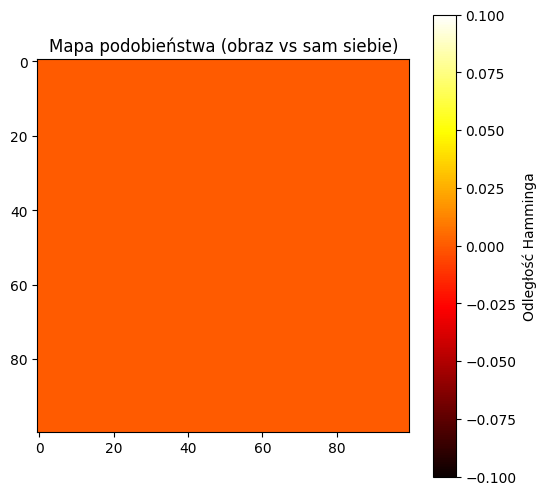

In [16]:
# Porównanie obrazu z samym sobą (powinno dać same zera)
similarity_self = census_similarity_map(test_img1, test_img1, window_size=3)

print(f"Mapa podobieństwa obrazu z samym sobą:")
print(f"Min: {similarity_self.min()}, Max: {similarity_self.max()}")
print(f"Suma niezerowych wartości: {np.sum(similarity_self > 0)}")
print(f"Oczekiwane: wszystkie wartości powinny być 0")

plt.figure(figsize=(6, 6))
plt.imshow(similarity_self, cmap='hot')
plt.colorbar(label='Odległość Hamminga')
plt.title('Mapa podobieństwa (obraz vs sam siebie)')
plt.show()

Mapa podobieństwa między różnymi obrazami:
Min: 0, Max: 5
Średnia odległość: 2.91


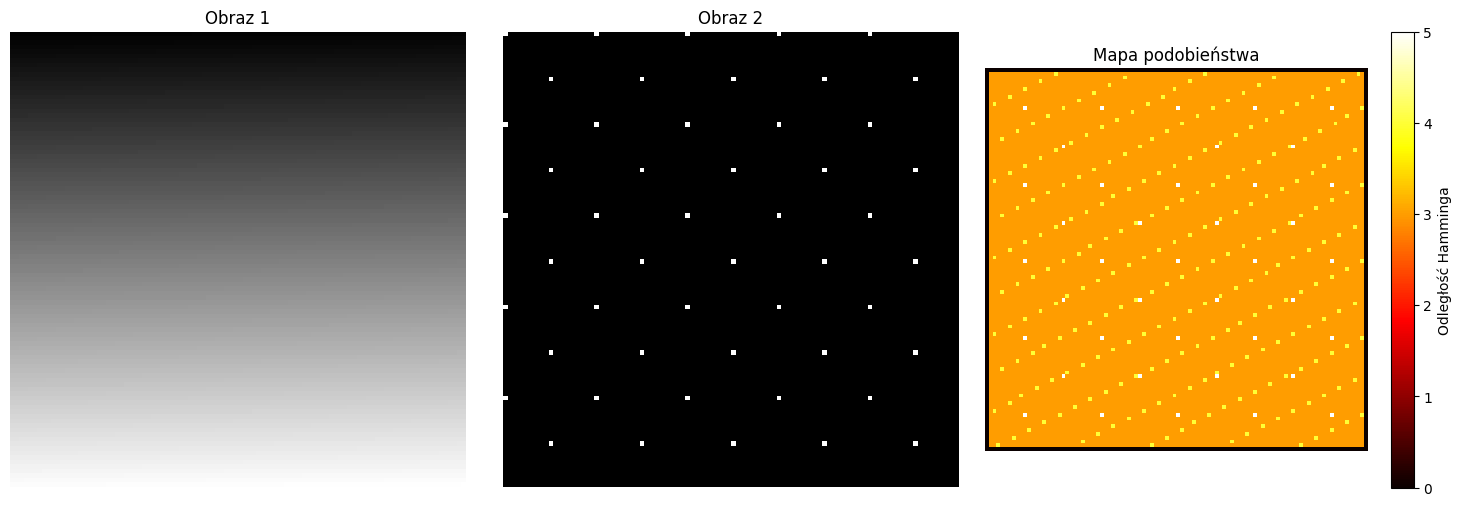

In [17]:
# Porównanie dwóch różnych obrazów
similarity_diff = census_similarity_map(test_img1, test_img2, window_size=3)

print(f"Mapa podobieństwa między różnymi obrazami:")
print(f"Min: {similarity_diff.min()}, Max: {similarity_diff.max()}")
print(f"Średnia odległość: {similarity_diff.mean():.2f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_img1, cmap='gray')
axes[0].set_title('Obraz 1')
axes[0].axis('off')

axes[1].imshow(test_img2, cmap='gray')
axes[1].set_title('Obraz 2')
axes[1].axis('off')

im = axes[2].imshow(similarity_diff, cmap='hot')
axes[2].set_title('Mapa podobieństwa')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], label='Odległość Hamminga')

plt.tight_layout()
plt.show()

### Zadanie 5: Wyszukiwanie wzorca na obrazie

Zaimplementuj funkcję `find_pattern`, która wyszukuje podany wzorzec (template) na obrazie przy użyciu transformaty Census.

**Parametry:**
- `image`: obraz, w którym szukamy wzorca
- `template`: wzorzec do znalezienia
- `window_size`: rozmiar okna dla transformaty Census
- `threshold`: maksymalna dopuszczalna odległość Hamminga (domyślnie 20)

**Zwraca:**
- Lista krotek (x, y, score) z pozycjami i wynikami dopasowania, gdzie score to średnia odległość Hamminga

**Wskazówka:** 
1. Oblicz transformatę Census dla obrazu i wzorca
2. Przesuń wzorzec po całym obrazie (sliding window)
3. Dla każdej pozycji oblicz średnią odległość Hamminga między wzorcem a fragmentem obrazu
4. Zwróć pozycje, gdzie odległość < threshold

In [18]:
def find_pattern(image, template, window_size=3, threshold=20):
    # TODO: Zaimplementuj wyszukiwanie wzorca
    # 1. Oblicz transformatę Census dla obrazu i wzorca
    # 2. Pobierz wymiary wzorca
    # 3. Utwórz listę na wyniki: matches = []
    # 4. Dla każdej możliwej pozycji (x, y) w obrazie:
    #    a) Wytnij fragment obrazu o rozmiarze wzorca
    #    b) Oblicz średnią odległość Hamminga między fragmentem a wzorcem
    #    c) Jeśli średnia < threshold, dodaj (x, y, średnia) do matches
    # 5. Posortuj matches według score (rosnąco)
    # 6. Zwróć matches
    
    pass

In [19]:
# ROZWIĄZANIE - USUNĄĆ PRZED ZAJĘCIAMI
def find_pattern(image, template, window_size=3, threshold=20):
    # Oblicz transformaty Census



    tpl_rows, tpl_cols = template.shape
    img_rows, img_cols = image.shape
    offset = tpl_cols // 2

    census_img = census_transform(image, window_size)
    census_pattern = census_pixel(template, offset, offset, window_size)

    matches = []
    
    # Przeszukaj obraz
    for y in range(offset, img_rows - offset):
        for x in range(offset, img_cols - offset):
            distance = hamming_distance(census_pattern, census_img[y,x])
            
            if distance <= threshold:
                matches.append((x, y, distance))
    
    # Sortuj według score (najlepsze dopasowania pierwsze)
    #matches.sort(key=lambda m: m[2])
    
    return matches

### Test 5: Wyszukiwanie wzorca

Rozmiar obrazu: (100, 100)
Rozmiar wzorca: (3, 3)
Umieszczono wzorzec w pozycjach: [(30, 40), (80, 90), (70, 20)]

Znaleziono 18 dopasowań:
  1. Pozycja: (52, 11), Score: 0.00
  2. Pozycja: (66, 13), Score: 0.00
  3. Pozycja: (70, 20), Score: 0.00
  4. Pozycja: (43, 21), Score: 0.00
  5. Pozycja: (39, 23), Score: 0.00
  6. Pozycja: (70, 26), Score: 0.00
  7. Pozycja: (27, 28), Score: 0.00
  8. Pozycja: (22, 31), Score: 0.00
  9. Pozycja: (45, 37), Score: 0.00
  10. Pozycja: (30, 40), Score: 0.00
  11. Pozycja: (82, 46), Score: 0.00
  12. Pozycja: (26, 48), Score: 0.00
  13. Pozycja: (57, 52), Score: 0.00
  14. Pozycja: (62, 52), Score: 0.00
  15. Pozycja: (33, 65), Score: 0.00


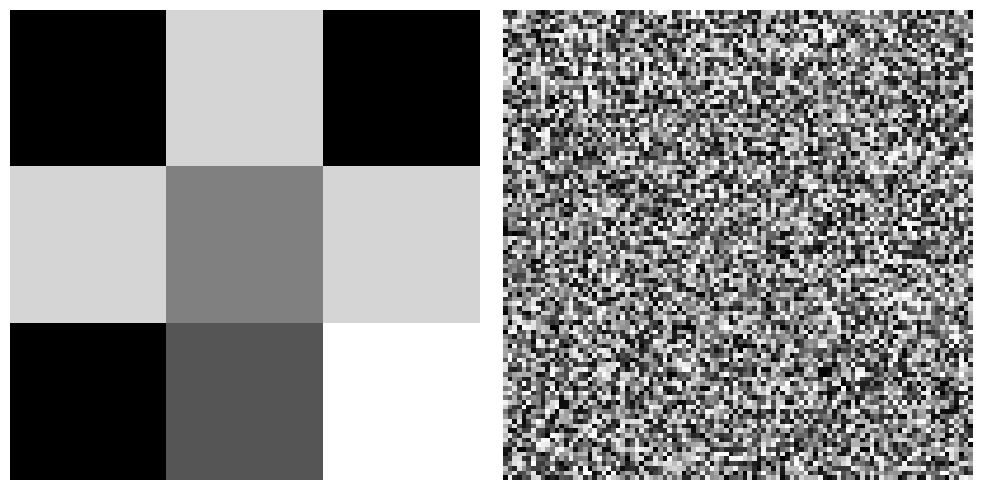

In [20]:
# Stwórz obraz z ukrytym wzorcem
base_image = np.random.randint(50, 200, (100, 100), dtype=np.uint8)

# Stwórz charakterystyczny wzorzec
pattern = np.array([
    [100, 150, 100],
    [150, 130, 150],
    [100, 120, 160]
], dtype=np.uint8)

# Powiększ wzorzec dla lepszej widoczności
#pattern = np.kron(pattern, np.ones((3, 3), dtype=np.uint8))

# Umieść wzorzec w kilku miejscach obrazu
positions = [(30, 40), (80, 90), (70, 20)]
for px, py in positions:
    ph, pw = pattern.shape
    base_image[py-1:py+ph-1, px-1:px+pw-1] = pattern

print(f"Rozmiar obrazu: {base_image.shape}")
print(f"Rozmiar wzorca: {pattern.shape}")
print(f"Umieszczono wzorzec w pozycjach: {positions}")

# Wyszukaj wzorzec
matches = find_pattern(base_image, pattern, window_size=3, threshold=0)

print(f"\nZnaleziono {len(matches)} dopasowań:")
for i, (x, y, score) in enumerate(matches[:15]):  # Pokaż top 15
    print(f"  {i+1}. Pozycja: ({x}, {y}), Score: {score:.2f}")
show_images([pattern, base_image])


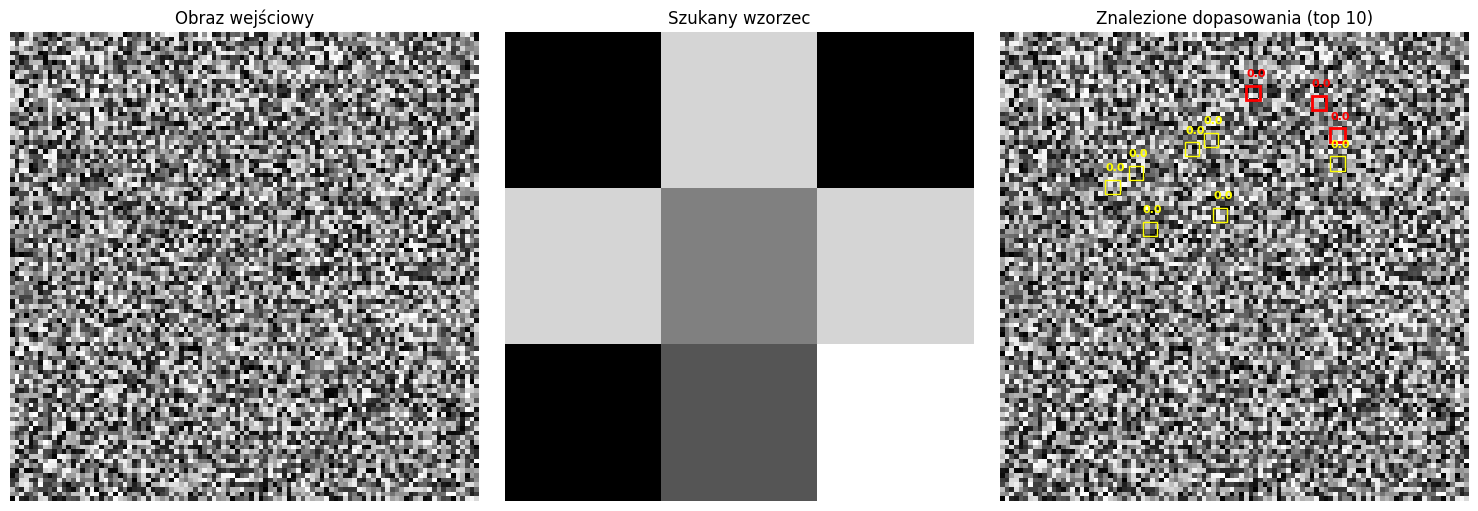

In [25]:
# Wizualizacja wyników wyszukiwania
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Obraz oryginalny
axes[0].imshow(base_image, cmap='gray')
axes[0].set_title('Obraz wejściowy')
axes[0].axis('off')

# Wzorzec
axes[1].imshow(pattern, cmap='gray')
axes[1].set_title('Szukany wzorzec')
axes[1].axis('off')

# Wyniki z zaznaczonymi dopasowaniami
axes[2].imshow(base_image, cmap='gray')
ph, pw = pattern.shape

# Zaznacz znalezione dopasowania
for i, (x, y, score) in enumerate(matches[:10]):  # Pokaż top 10
    rect = plt.Rectangle((x, y), pw, ph, 
                         fill=False, 
                         edgecolor='red' if i < 3 else 'yellow',
                         linewidth=2 if i < 3 else 1)
    axes[2].add_patch(rect)
    axes[2].text(x, y-2, f'{score:.1f}', 
                color='red' if i < 3 else 'yellow',
                fontsize=8, fontweight='bold')

axes[2].set_title(f'Znalezione dopasowania (top {min(10, len(matches))})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Testy i przykłady zastosowań

### Test 4: Mapa podobieństwa

### Przykład zastosowania: Detekcja zmian

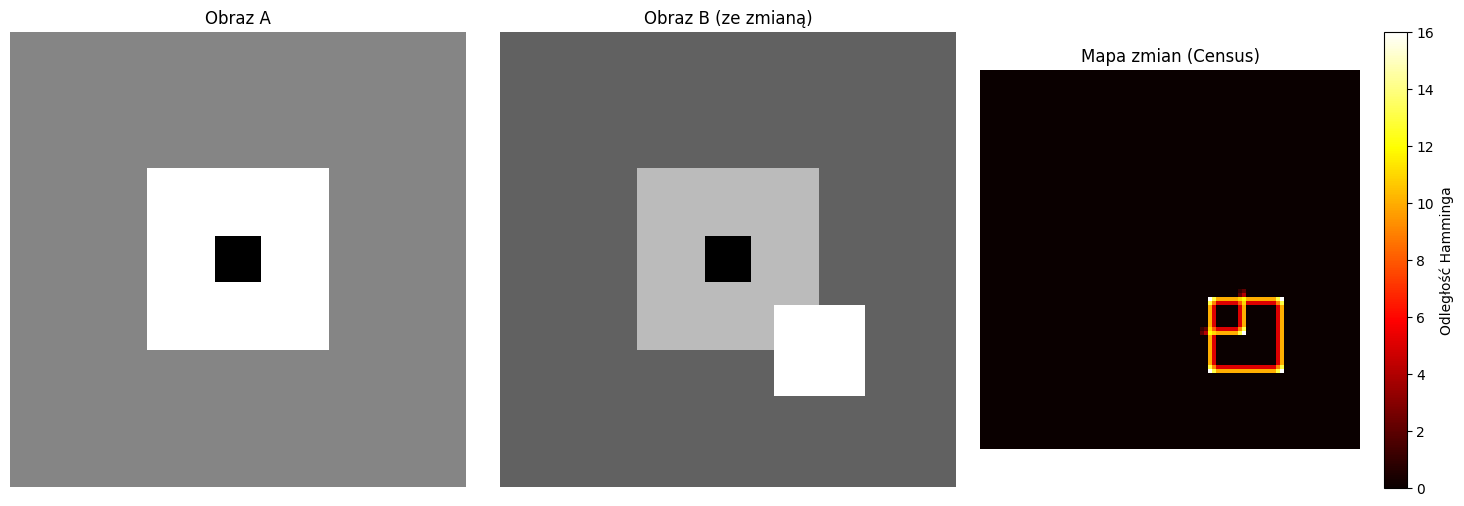

Obszary z dużą zmianą (odległość > 5): 100 pikseli


In [22]:
# Stwórz dwa podobne obrazy z małą różnicą
img_a = test_img3.copy()
img_b = test_img3.copy()
img_b[60:80, 60:80] = 255  # Dodaj jasny kwadrat

# Oblicz mapę podobieństwa
change_map = census_similarity_map(img_a, img_b, window_size=5)

# Wizualizacja
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_a, cmap='gray')
axes[0].set_title('Obraz A')
axes[0].axis('off')

axes[1].imshow(img_b, cmap='gray')
axes[1].set_title('Obraz B (ze zmianą)')
axes[1].axis('off')

im = axes[2].imshow(change_map, cmap='hot')
axes[2].set_title('Mapa zmian (Census)')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], label='Odległość Hamminga')

plt.tight_layout()
plt.show()

print(f"Obszary z dużą zmianą (odległość > 5): {np.sum(change_map > 5)} pikseli")

### Przykład zastosowania: Wyszukiwanie logo na zdjęciu

Znaleziono 12 wystąpień logo
Oczekiwano: 3 wystąpień


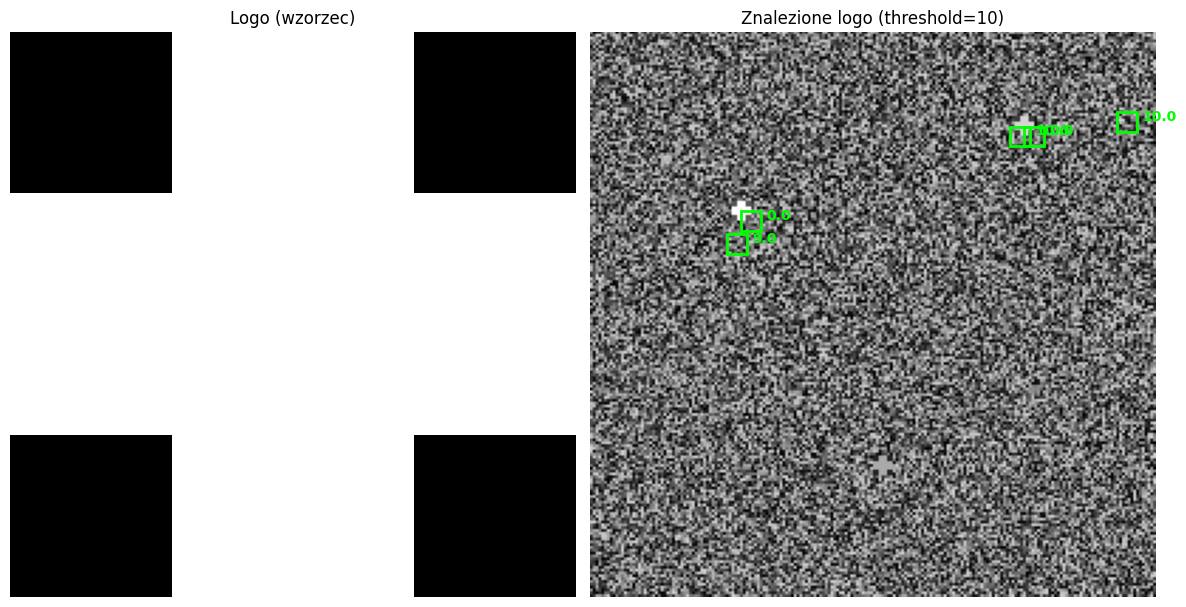


Transformata Census jest odporna na zmiany jasności!
Wszystkie wystąpienia logo zostały znalezione mimo różnej jasności.


In [23]:
# Stwórz obraz z "logo"
large_image = np.random.randint(80, 180, (200, 200), dtype=np.uint8)

# Proste "logo" - krzyżyk
logo = np.ones((7, 7), dtype=np.uint8) * 120
logo[2:5, :] = 200  # Pozioma linia
logo[:, 2:5] = 200  # Pionowa linia

# Umieść logo w różnych miejscach z różnymi jasnościami
logo_positions = [
    (50, 60, 1.0),   # Oryginalna jasność
    (150, 30, 0.9),  # Ciemniejsze
    (100, 150, 0.8), # Jaśniejsze
]

for px, py, brightness in logo_positions:
    modified_logo = np.clip(logo * brightness, 0, 255).astype(np.uint8)
    lh, lw = logo.shape
    large_image[py:py+lh, px:px+lw] = modified_logo

# Wyszukaj logo
logo_matches = find_pattern(large_image, logo, window_size=7, threshold=10)

print(f"Znaleziono {len(logo_matches)} wystąpień logo")
print(f"Oczekiwano: {len(logo_positions)} wystąpień")

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(logo, cmap='gray')
axes[0].set_title('Logo (wzorzec)')
axes[0].axis('off')

axes[1].imshow(large_image, cmap='gray')
lh, lw = logo.shape

for x, y, score in logo_matches[:5]:
    rect = plt.Rectangle((x, y), lw, lh, 
                         fill=False, edgecolor='lime', linewidth=2)
    axes[1].add_patch(rect)
    axes[1].text(x+lw+2, y+lh//2, f'{score:.1f}', 
                color='lime', fontsize=10, fontweight='bold')

axes[1].set_title(f'Znalezione logo (threshold=10)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\nTransformata Census jest odporna na zmiany jasności!")
print("Wszystkie wystąpienia logo zostały znalezione mimo różnej jasności.")

## Podsumowanie

W tym laboratorium zaimplementowaliśmy:
1. Transformatę Census dla pojedynczego piksela i całego obrazu
2. Odległość Hamminga do porównywania reprezentacji Census
3. Mapę podobieństwa między obrazami

Transformata Census jest efektywną metodą porównywania lokalnych struktur obrazu, odporną na zmiany oświetlenia.